In [2]:
import numpy as np
import pandas as pd
import json
import pickle
import os
import numpy as np
import pickle, sys, os
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

/Users/manohar/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/manohar/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/manohar/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/manohar/anaconda3/lib/python3.6/si

In [3]:
df=pd.read_excel('Batch_3666796_batch_results.xlsx')

In [3]:
df.shape

(739, 7)

In [5]:
df.iloc[10,:].

AssignmentStatus                                                        Approved
ApprovalTime                                        Fri Jun 07 13:34:35 PDT 2019
Input.sentence                 Early insulin secretion is important for the r...
Answer.Causal word / phrase                                     is important for
Answer.Cause word / phrase                               Early insulin secretion
Answer.Effect word / phrase    efficient suppression of endogenous glucose pr...
Answer.Label-relationship                                                  Cause
Name: 10, dtype: object

In [5]:
df.columns=['as', 'at', 'sentences', 'cc', 'c', 'e', 'ans']

In [6]:
df=df.apply(lambda x: x.astype(str).str.lower())

In [7]:
df[['sentences','dataset']].to_csv('mturk_sents.csv')

KeyError: "['dataset'] not in index"

In [9]:
t=[]
words=[]
X_train=[]
Y_train=['cc', 'c', 'e', 'n']

for ind, val in df.iterrows():
    l=[]
    sent=val.sentences.split()
    cc=val['cc'].split()
    c=val['c'].split()
    e=val['e'].split()

    for i in sent:
        if i in cc:
            l.append((i+'/cc'))
        elif i in c:
            l.append((i+'/c'))
        elif i in e:
            l.append((i+'/e'))
        else:
            l.append((i+'/n'))
    t.append(l)

In [279]:
#X_train list of split sentences [[akmak,anfa], [afjnadn,jadnfud],....]
#Y_train list of lists of tags for sentences [[c,n,cc,e], [c,e],...]
#words is all words set
#tags is set of all tags
#

In [280]:
with open(r'ndtv.pickle', 'rb') as f:
    ndtv=pickle.loads(f.read())
with open(r'toi_key_extract.pickle', 'rb') as f:
    toi=pickle.loads(f.read())
    


In [281]:
ndtv=[j.strip().replace('-', ',') for i in ndtv for j in i]
toi=[j.strip().replace('-', ',') for j in toi ]

In [282]:
toi[0]

'meanwhile, northern parts of madhya pradesh , districts of bundelkhand and vindhya region also continued to experience heatwave conditions'

In [283]:

toi_vocab=[l for v in [i.split() for i in toi] for l in v]
ndtv_vocab=[l for v in [i.split() for i in ndtv] for l in v]
news_vocab=toi_vocab+ndtv_vocab

In [284]:
len(new_vocab)

84511

In [285]:
new_vocab=set(news_vocab)

In [10]:
X_train = []
Y_train = []

words = []
tags = []

with_slash = False
n_omitted = 0

for line in t:
    if(len(line)>0):
        tempX = []
        tempY = []
        for word in line:
            try:            
                w, tag = word.split('/')
            except:
                # with_slash = True
                n_omitted = n_omitted + 1
                break

            w = w.lower()
            words.append(w)
            tags.append(tag)

            tempX.append(w)
            tempY.append(tag)
        
        X_train.append(tempX)
        Y_train.append(tempY)


print('OMITTED sentences: ', n_omitted, '\n')
print('TOTAL NO OF SAMPLES: ', len(X_train), '\n')


print('sample X_train: ', X_train[42], '\n')
print('sample Y_train: ', Y_train[42], '\n')

words = set(words)
tags = set(tags)

print('VOCAB SIZE: ', len(words))
print('TOTAL TAGS: ', len(tags))

assert len(X_train) == len(Y_train)

OMITTED sentences:  22 

TOTAL NO OF SAMPLES:  739 

sample X_train:  ['t2dm', 'causes', 'brain', 'insulin', 'resistance,', 'oxidative', 'stress,', 'and', 'cognitive', 'impairment,', 'but', 'its', 'aggregate', 'effects', 'fall', 'far', 'short', 'of', 'mimicking', 'ad;'] 

sample Y_train:  ['n', 'n', 'e', 'e', 'n', 'e', 'e', 'n', 'e', 'n', 'n', 'n', 'c', 'c', 'cc', 'cc', 'cc', 'n', 'e', 'n'] 

VOCAB SIZE:  2851
TOTAL TAGS:  4


In [287]:
words=(set(list(words)+list(new_vocab)))

In [11]:

word2int = {}
int2word = {}

for i, word in enumerate(words):
    word2int[word] = i+1
    int2word[i+1] = word

tag2int = {}
int2tag = {}

for i, tag in enumerate(tags):
    tag2int[tag] = i+1
    int2tag[i+1] = tag

X_train_numberised = []
Y_train_numberised = []

for sentence in X_train:
    tempX = []
    for word in sentence:
        tempX.append(word2int[word])
    X_train_numberised.append(tempX)

for tags in Y_train:
    tempY = []
    for tag in tags:
        tempY.append(tag2int[tag])
    Y_train_numberised.append(tempY)

print('sample X_train_numberised: ', X_train_numberised[42], '\n')
print('sample Y_train_numberised: ', Y_train_numberised[42], '\n')

X_train_numberised = np.asarray(X_train_numberised)
Y_train_numberised = np.asarray(Y_train_numberised)

pickle_files = [X_train_numberised, Y_train_numberised, word2int, int2word, tag2int, int2tag]


sample X_train_numberised:  [2460, 500, 2600, 1698, 59, 894, 1713, 2170, 1457, 1537, 41, 2327, 983, 2650, 1910, 208, 2818, 434, 2199, 572] 

sample Y_train_numberised:  [3, 3, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 1, 1, 4, 4, 4, 3, 2, 3] 



In [12]:
embeddings_index = {}

with open('glove.6B/glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


In [13]:

# PARAMETERS ================
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
TEST_SPLIT = 0.1
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 8


In [16]:
X, y, word2int, int2word, tag2int, int2tag = pickle_files 

In [17]:
def generator(all_X, all_y, n_classes, batch_size=BATCH_SIZE):
    num_samples = len(all_X)

    while True:

        for offset in range(0, num_samples, batch_size):
            
            X = all_X[offset:offset+batch_size]
            y = all_y[offset:offset+batch_size]

            y = to_categorical(y, num_classes=n_classes)


            yield shuffle(X, y)


In [18]:
n_tags = len(tag2int)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pad_sequences(y, maxlen=MAX_SEQUENCE_LENGTH)

# y = to_categorical(y, num_classes=len(tag2int) + 1)

print('TOTAL TAGS', len(tag2int))
print('TOTAL WORDS', len(word2int))


TOTAL TAGS 4
TOTAL WORDS 2851


In [19]:

# shuffle the data
X, y = shuffle(X, y)

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT,random_state=42)

# split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SPLIT, random_state=1)

n_train_samples = X_train.shape[0]
n_val_samples = X_val.shape[0]
n_test_samples = X_test.shape[0]
y_test = to_categorical(y_test, num_classes=n_tags+1)

print('We have %d TRAINING samples' % n_train_samples)
print('We have %d VALIDATION samples' % n_val_samples)
print('We have %d TEST samples' % n_test_samples)


We have 598 TRAINING samples
We have 67 VALIDATION samples
We have 74 TEST samples


In [20]:
train_generator = generator(all_X=X_train, all_y=y_train, n_classes=n_tags + 1)
validation_generator = generator(all_X=X_val, all_y=y_val, n_classes=n_tags + 1)



In [21]:

print('Total %s word vectors.' % len(embeddings_index))

# + 1 to include the unkown word
embedding_matrix = np.random.random((len(word2int) + 1, EMBEDDING_DIM))

for word, i in word2int.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embeddings_index will remain unchanged and thus will be random.
        embedding_matrix[i] = embedding_vector

print('Embedding matrix shape', embedding_matrix.shape)
print('X_train shape', X_train.shape)

Total 400000 word vectors.
Embedding matrix shape (2852, 100)
X_train shape (598, 100)


In [31]:
model=0
embedding_layer = Embedding(len(word2int) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedded_sequences)
preds = TimeDistributed(Dense(n_tags + 1, activation='softmax'))(l_lstm)
model = Model(sequence_input, preds)


In [32]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - Bidirectional LSTM")
model.summary()

model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          285200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          234496    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 100, 5)            1285      
Total params: 520,981
Trainable params: 520,981
Non-trainable params: 0
_________________________________________________________________


In [33]:

h=model.fit_generator(train_generator, 
                     steps_per_epoch=n_train_samples//BATCH_SIZE,
                     validation_data=validation_generator,
                     validation_steps=n_val_samples//BATCH_SIZE,
                     epochs=25,
                     verbose=1,
                     workers=1)
# fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, 
#               validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, 
#               max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)


Epoch 1/25
74/74 [==============================] - 16s 222ms/step - loss: 0.3270 - acc: 0.8633 - val_loss: 0.2729 - val_acc: 0.8936
Epoch 2/25
74/74 [==============================] - 15s 204ms/step - loss: 0.2741 - acc: 0.8837 - val_loss: 0.2634 - val_acc: 0.8967
Epoch 3/25
74/74 [==============================] - 17s 224ms/step - loss: 0.2657 - acc: 0.8868 - val_loss: 0.2837 - val_acc: 0.8731
Epoch 4/25
74/74 [==============================] - 17s 236ms/step - loss: 0.2570 - acc: 0.8914 - val_loss: 0.2847 - val_acc: 0.8687
Epoch 5/25
74/74 [==============================] - 17s 229ms/step - loss: 0.2477 - acc: 0.8962 - val_loss: 0.2930 - val_acc: 0.8645
Epoch 6/25
74/74 [==============================] - 17s 223ms/step - loss: 0.2378 - acc: 0.9014 - val_loss: 0.2770 - val_acc: 0.8825
Epoch 7/25
74/74 [==============================] - 18s 239ms/step - loss: 0.2283 - acc: 0.9057 - val_loss: 0.2714 - val_acc: 0.8852
Epoch 8/25
74/74 [==============================] - 17s 226ms/step - 

In [35]:
import matplotlib.pyplot as plt

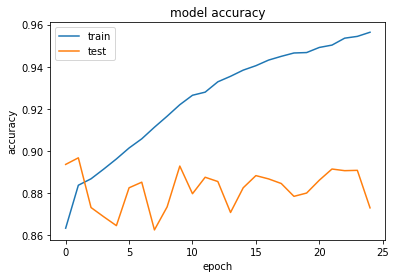

In [36]:
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

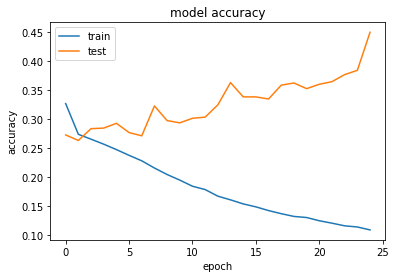

In [37]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
if not os.path.exists('Models/'):
    print('MAKING DIRECTORY Models/ to save model file')
    os.makedirs('Models/')

train = True

if train:
    model.save('Models/model_0622_v4.h5')
    print('MODEL SAVED in Models/ as model.h5')
else:
    from keras.models import load_model
    model = load_model('Models/model_0622_v4.h5')

# y_test = to_categorical(y_test, num_classes=n_tags+1)
test_results = model.evaluate(X_test, y_test, verbose=1)
print('TEST LOSS %f \nTEST ACCURACY: %f' % (test_results[0], test_results[1]))


MODEL SAVED in Models/ as model.h5
74/74 [==============================] - 0s 3ms/step
TEST LOSS 0.415427 
TEST ACCURACY: 0.892568


In [26]:
y_pred=model.predict(X_test, verbose=1)
yp=[y.argmax(1) for y in y_pred]
yt=[t.argmax(1) for t in y_test]
ytt=[m for n in [[int2tag[j] for j in k if j !=0] for k in yt] for m in n]
ypp=[m for n in [[int2tag[j] for j in k if j !=0] for k in yp] for m in n]

74/74 [==============================] - 1s 7ms/step


In [27]:
Xtt=[m for n in [[int2word[j] for j in k if j not in [0]] for k in X_test] for m in n]

In [28]:
pred_df=pd.DataFrame(list(zip(Xtt, ytt, ypp)))
pred_df.columns=['word', 'true', 'pred']
pred_df_sub=pred_df[pred_df['true']!=pred_df['pred']]

In [30]:
confusion_matrix(pred_df['true'], pred_df['pred'], labels=['e', 'c', 'cc', 'n'])

array([[120,  15,  26, 175],
       [ 15, 125,  26,  61],
       [ 34,  44,  59, 162],
       [ 69,  94,  74, 490]])

In [38]:
pred_df_sub.word.value_counts()

of                52
the               49
in                24
to                21
and               19
is                15
a                 13
with              11
alzheimer          8
are                8
not                8
disease            7
for                6
vascular           5
has                5
as                 5
which              5
cognitive          5
insulin            5
amyloid            5
secretion          4
may                4
age                4
been               4
ad                 4
be                 4
characteristic     3
it                 3
neuronal           3
type               3
                  ..
conditional        1
metabolites        1
clinical           1
increases          1
acid               1
diabetes,          1
dependent)         1
methyl             1
favor              1
deficits           1
2216),             1
cardioembolic      1
do                 1
hallmark           1
improve            1
demonstrate        1
cortical     

In [33]:
xtest=[[int2word[i] for i in j if i!=0] for j in X_test]

In [34]:
' '.join(xtest[0])

'confirmation that presenilin is the catalytic site of c secretase has provided a linchpin: all dominant mutations causing early onset ad occur either in the substrate (amyloid precursor protein, app) or the protease (presenilin) of the reaction that generates abeta'

In [35]:
[int2tag[j] for j in [np.where(i==1)[0][0] for i in y_test[0]] if j !=0]

['n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'cc',
 'cc',
 'cc',
 'cc',
 'e',
 'e',
 'e',
 'n',
 'n',
 'n',
 'n',
 'c',
 'c',
 'c',
 'c',
 'c',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n',
 'n']

In [169]:
ndtv[:10]

['which means the expected scanty rainfall this year , when the state is facing is second consecutive year of drought , will be enough for their needs',
 '"bangalore receives around 900,1000mm of rainfall except for these very drought years," said mr shivakumar, whose work involves the field of renewable energy and rainwater harvesting',
 'a tidal surge was expected to flood low,lying areas near mackay as the storm whipped up waves and currents and lifted sea levels',
 "the tamil nadu government today revived a traditional water resource management system involving public in the state's worst drought in more than a century",
 'he believes that the project will ensure adequate water supply even during drought unlike the crop loss he suffered two years ago due to drought',
 'seventeen farmers had killed themselves; and as many as 100 deaths had been linked to the drought',
 '2017,03,14 andaman and nicobar islands,earthquake andaman and nicobar islands,earthquake andamans,earthquake nicob

In [171]:
ndtv_numberised=[]

for sentence in ndtv:
    tempX = []
    for word in sentence.split():
        tempX.append(word2int[word])
    ndtv_numberised.append(tempX)

In [172]:
news_test = pad_sequences(ndtv_numberised, maxlen=MAX_SEQUENCE_LENGTH)

In [212]:
result_2=model.predict(news_test, verbose=1)

3268/3268 [==============================] - 8s 2ms/step


In [192]:
result_1.shape

(3268, 100, 5)

In [194]:
result_1[0][0]

array([  9.99999881e-01,   2.61830682e-08,   2.28022401e-08,
         1.39889877e-08,   7.14229103e-08], dtype=float32)

In [211]:
result[0].argmax(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2])

In [215]:
result_2[0].argmax(1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 1, 1, 4, 4, 3, 3, 1, 1, 1,
       1, 1, 3, 3, 2, 2, 1, 1])

In [216]:
ndtv_results=[]
for i in result_2:
    ndtv_results.append(i.argmax(1))

In [218]:
ndtv_results[70]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 1])

In [226]:
ndtv[0]

'which means the expected scanty rainfall this year , when the state is facing is second consecutive year of drought , will be enough for their needs'

In [231]:
ndtv_res=[[int2tag[i] for i in n if i!=0] for n in ndtv_results]

In [234]:
len(ndtv_res)

3268

In [237]:
results=[]
for i in range(len(ndtv_res)):
    results.append(' '.join([m+str('/')+str(n) for m,n in zip(ndtv[i].split(),ndtv_res[i])]))

In [260]:
results[0].split(' ')

['which/n',
 'means/cc',
 'the/cc',
 'expected/cc',
 'scanty/cc',
 'rainfall/cc',
 'this/cc',
 'year/cc',
 ',/n',
 'when/cc',
 'the/c',
 'state/c',
 'is/e',
 'facing/e',
 'is/cc',
 'second/cc',
 'consecutive/c',
 'year/c',
 'of/c',
 'drought/c',
 ',/c',
 'will/cc',
 'be/cc',
 'enough/n',
 'for/n',
 'their/c',
 'needs/c']

In [239]:
len(toi)

5127089

In [240]:
toi[0]

'm'

In [253]:
keywords=['flood', 'drought', 'flu', 'earthquake', 
          'tornado', 'heatwave', 'malaria', 'dengue', 
          'cholera', 'heat wave', 'water shortage']

In [254]:
keyword_dict=dict.fromkeys(keywords)

In [261]:
for i in keyword_dict:
    keyword_dict[i]=[]

In [263]:
for i in results:
    c=[]
    cc=[]
    e=[]
    for j in i.split():
        wrd=j.split('/')
        if wrd[0] in keywords:
            if wrd[1]=='c'
            c.append
            keyword_dict[j.split('/')[0]].append(i)

In [303]:
keyword_dict['heatwave'][0]

'the/cc sudden/cc rise/e in/cc day/e temperatures/cc and/cc the/cc prevailing/cc heatwave/c conditions/c in/c the/c state/c figured/c in/c the/c council/c on/cc thursday/cc'

In [306]:
for i in results:
    print(i)
    break

which/n means/cc the/cc expected/cc scanty/cc rainfall/cc this/cc year/cc ,/n when/cc the/c state/c is/e facing/e is/cc second/cc consecutive/c year/c of/c drought/c ,/c will/cc be/cc enough/n for/n their/c needs/c


In [363]:
ndtv_sent=[]
for ind, i in enumerate(ndtv):
    c=pd.Series(ndtv[ind].split())[[i for i, x in enumerate(ndtv_res[ind]) if x == "c"]].values
    cc=pd.Series(ndtv[ind].split())[[i for i, x in enumerate(ndtv_res[ind]) if x == "cc"]].values
    e=pd.Series(ndtv[ind].split())[[i for i, x in enumerate(ndtv_res[ind]) if x == "e"]].values
    ndtv_sent.append({'kws':set(ndtv[ind].split()).intersection(keywords), 'sent':i, 'c':c, 'cc':cc, 'e':e})
        

In [369]:
with open(r'tagged_data.pickle', 'wb') as f:
    f.write(pickle.dumps(ndtv_sent))

In [368]:
pd.DataFrame(ndtv_sent)

,c,cc,e,kws,sent
0,"[the, state, consecutive, year, of, drought, ,...","[means, the, expected, scanty, rainfall, this,...","[is, facing]",{drought},which means the expected scanty rainfall this ...
1,"[900,1000mm, of, energy, harvesting]","[except, for, very, work, involves, the, field...","[rainfall, drought, mr]",{drought},"""bangalore receives around 900,1000mm of rainf..."
2,"[flood, areas, near, mackay, as, the, storm, w...","[was, expected, to, up, waves, and, currents, ...","[tidal, surge]",{flood},"a tidal surge was expected to flood low,lying ..."
3,"[the, tamil, nadu, traditional, water, resourc...","[revived, a, involving]","[government, worst]",{drought},the tamil nadu government today revived a trad...
4,"[the, project, ensure, adequate, water, he, ye...","[even, during, due, to]","[supply, drought, unlike, crop, loss, suffered]",{drought},he believes that the project will ensure adequ...
5,[],"[been, linked, to, the, drought]",[farmers],{drought},seventeen farmers had killed themselves; and a...
6,"[2017,03,14, andaman, and, nicobar, andaman, a...",[],"[nicobar, islands,andaman, and, nicobar, islan...",{earthquake},"2017,03,14 andaman and nicobar islands,earthqu..."
7,"[9,magnitude, earthquake, hit, andaman, and, n...",[],[],{earthquake},"9,magnitude earthquake hit andaman and nicobar..."
8,"[tsunami, warning, earthquake]",[sends],[littoral],{earthquake},india has a dedicated tsunami warning centre t...
9,"[earthquake, measuring, 3]",[],[],{earthquake},another earthquake measuring 3


In [357]:
c=pd.Series(ndtv[0].split())[[i for i, x in enumerate(ndtv_res[0]) if x == "c"]].values
c=pd.Series(ndtv[0].split())[[i for i, x in enumerate(ndtv_res[0]) if x == "cc"]].values
c=pd.Series(ndtv[0].split())[[i for i, x in enumerate(ndtv_res[0]) if x == "e"]].values


array(['which', ',', 'enough', 'for'], dtype=object)

In [341]:
ndtv[0].split()

['which',
 'means',
 'the',
 'expected',
 'scanty',
 'rainfall',
 'this',
 'year',
 ',',
 'when',
 'the',
 'state',
 'is',
 'facing',
 'is',
 'second',
 'consecutive',
 'year',
 'of',
 'drought',
 ',',
 'will',
 'be',
 'enough',
 'for',
 'their',
 'needs']